In [10]:
# 1) (Optional) Installs — uncomment on first run
# !pip install -U matplotlib timm torchvision torch tqdm scikit-learn --quiet
!pip install -U open-clip-torch torchinfo --quiet
print('If you need packages, uncomment the pip lines above and run this cell.')

If you need packages, uncomment the pip lines above and run this cell.


In [11]:
# 2) Common imports + seeds
import math, random, os, time
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets, transforms

import torchinfo

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import open_clip

def set_seed(seed:int=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False

set_seed(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device is {device}")

Device is cuda


In [ ]:
from dataclasses import dataclass
from typing import Tuple

# Pick a lightweight variant for quick experiments


@dataclass
class Config:
    #model_name: str = "ViT-B-32"  # new MobileCLIP2 in open_clip
    #pretrained: str = "laion2b_s34b_b79k"
    model_name = 'MobileCLIP2-S0'   # alternatives: 'MobileCLIP2-S2', 'MobileCLIP2-B', 'MobileCLIP2-S3', 'MobileCLIP2-S4', 'MobileCLIP2-L-14'
    pretrained = 'dfndr2b'          # per MobileCLIP2 release in OpenCLIP


    image_size: int = 224
    batch_size: int = 256
    num_workers: int = 4
    max_epochs: int = 1

    # LR split: base vs prompt
    lr_base: float = 1e-5
    lr_prompt: float = 5e-3
    weight_decay: float = 0.05

    # Unfreeze (if you want a light finetune on top of prompt)
    unfreeze_layers: Tuple[str, ...] = tuple()  # e.g. ("visual.transformer.resblocks.11",)

    # CoOp prompt length
    prompt_len: int = 16

    # Overfit sanity tiny subset
    overfit_n_classes: int = 2
    overfit_k_per_class: int = 8
    overfit_epochs: int = 50


cfg = Config()
cfg


In [20]:
# --- Load model + preprocess ---
model, _, preprocess = open_clip.create_model_and_transforms(cfg.model_name, pretrained=cfg.pretrained)
tokenizer = open_clip.get_tokenizer(cfg.model_name)
model = model.to(device).eval()
#text_tower = getattr(model, "text", model)

torchinfo.summary(model)

Layer (type:depth-idx)                                                           Param #
CustomTextCLIP                                                                   1
├─TimmModel: 1-1                                                                 --
│    └─FastVit: 2-1                                                              --
│    │    └─Sequential: 3-1                                                      7,424
│    │    └─Sequential: 3-2                                                      10,728,256
│    │    └─MobileOneBlock: 3-3                                                  146,496
│    │    └─ClassifierHead: 3-4                                                  524,800
│    └─Sequential: 2-2                                                           --
├─TextTransformer: 1-2                                                           301,568
│    └─Embedding: 2-3                                                            25,296,896
│    └─Transformer: 2-4               

Val dataset:   5000 images, 10 classes


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0c8ed35580>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f0c8ed35580>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    if w.is_alive():    
 self._shutdown_workers()  
     File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
 ^^    ^if w.is_alive():^^^^^
^^ ^^
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process'
            ^ ^ ^^^ ^^^^^^^^^^^^^^^^^^^^

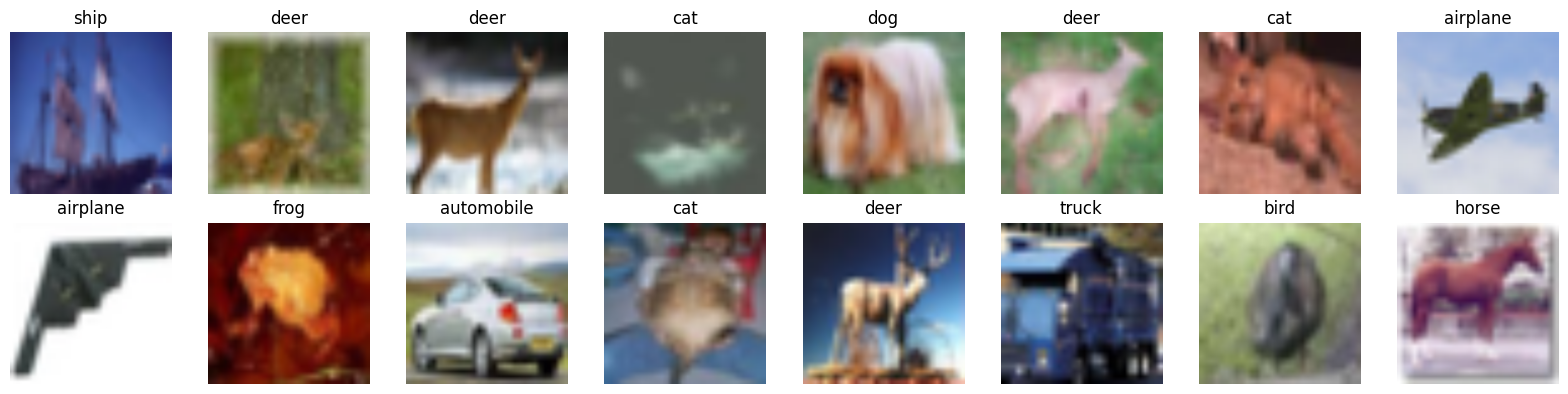

In [41]:
full_train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=preprocess)
full_train_size = len(full_train_ds)
val_size = int(full_train_size * 0.1)

train_ds, val_ds = torch.utils.data.random_split(full_train_ds, [full_train_size - val_size, val_size])
overfit_train_ds, overfit_val_ds, _ = torch.utils.data.random_split(full_train_ds, [16, 16, full_train_size - 32])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=2)

overfit_train_loader = DataLoader(overfit_train_ds, batch_size=128, shuffle=False, num_workers=0)
overfit_val_loader = DataLoader(overfit_val_ds, batch_size=128, shuffle=False, num_workers=0)

classnames = full_train_ds.classes
num_classes = len(classnames)

print(f"Val dataset:   {len(val_ds)} images, {num_classes} classes")

def show_batch(dl: DataLoader, rows: int=2, cols: int=8):
    batch = next(iter(dl))
    images, labels = batch
    fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i in range(rows):
        for j in range(cols):
            idx = i*cols + j
            if idx >= len(images):
                break
            img = images[idx].permute(1, 2, 0).cpu().numpy()
            label = classnames[labels[idx]]
            axs[i, j].imshow(img)
            axs[i, j].set_title(label)
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

show_batch(val_loader, rows=2, cols=8)

In [21]:
class HardcodedPrompt(nn.Module):
    def __init__(self, clip_model, classnames):
        super().__init__()
        prompts = [f"a photo of a {c}" for c in classnames]
        text_tokens = tokenizer(prompts).to(device)
        text_features = clip_model.encode_text(text_tokens)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        self.register_buffer("text_features", text_features)

    def forward_text_features(self):
        return self.text_features


In [51]:
class ZeroShotClassifier(nn.Module):
    def __init__(self, clip_model, classnames):
        super().__init__()
        self.model = clip_model
        #self.device = device
        self.classnames = classnames
        self.hardcoded_prompts = HardcodedPrompt(clip_model, classnames)

    def forward(self, images):
        with torch.no_grad():
            images = images.to(device)
            image_features = self.model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = self.hardcoded_prompts.forward_text_features()
            logits = 100.0 * image_features @ text_features.T
        return logits

In [46]:
prompts = [f"a photo of a {c}" for c in classnames]
with torch.no_grad():
    text_tokens   = tokenizer(prompts).to(device)
    text_features = model.encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

correct = total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        image_features = model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        # CLIP-style scaled cosine sims
        logits = 100.0 * image_features @ text_features.T
        preds = logits.argmax(dim=-1).cpu()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Zero-shot CIFAR-10 accuracy: {100*correct/total:.2f}%")

Zero-shot CIFAR-10 accuracy: 94.58%


In [16]:
class CoOpPrompt(nn.Module):
    def __init__(self, clip_model, tokenizer, classnames, n_ctx=16, init_scale=0.02, device="cpu"):
        super().__init__()
        self.model = clip_model
        self.text_tower = getattr(self.model, "text", self.model)
        #self.visual_tower = getattr(self.model, "visual", self.model)
        self.tokenizer = tokenizer
        self.classnames = classnames
        self.device = device

        # Text transformer sizes
        self.context_length = getattr(self.text_tower, "context_length", 77)
        self.width = self.text_tower.token_embedding.weight.shape[1]

        # Learnable context (n_ctx continuous "tokens")
        self.ctx = nn.Parameter(init_scale * torch.randn(n_ctx, self.width))

        # Tokenize bare classnames (we'll prepend soft context ourselves)
        with torch.no_grad():
            self.class_token_ids = tokenizer(classnames).to(device)  # [C, L]
            # EOT trick: in CLIP tokenization the EOT id is the largest id in each row
            self.eot_indices = self.class_token_ids.argmax(dim=-1)   # [C]

        # Freeze CLIP
        for p in self.text_tower.parameters():
            p.requires_grad = False

    def forward_text_features(self):
        C = len(self.classnames)
        token_ids = self.class_token_ids  # [C, L]

        # Frozen lookup for class tokens
        with torch.no_grad():
            tok_emb = self.text_tower.token_embedding(token_ids)  # [C, L, W]

        sos = tok_emb[:, :1, :]         # [C,1,W]
        class_part = tok_emb[:, 1:, :]  # [C,L-1,W]

        # Learnable context repeated across classes
        ctx = self.ctx.unsqueeze(0).expand(C, -1, -1)  # [C, n_ctx, W]

        # [SOS] + [CTX...CTX] + [class tokens...]
        x = torch.cat([sos, ctx, class_part], dim=1)  # [C, 1+n_ctx+(L-1), W]

        # Pad/truncate to model context length
        L_target = getattr(self.text_tower, "context_length", 77)
        if x.size(1) > L_target:
            x = x[:, :L_target, :]
        elif x.size(1) < L_target:
            pad_len = L_target - x.size(1)
            pad = torch.zeros(C, pad_len, x.size(2), device=self.device, dtype=x.dtype)
            x = torch.cat([x, pad], dim=1)
        L = x.size(1)

        # Dtypes, pos emb, and (optional) attn mask, all sliced to L
        text_dtype = self.text_tower.token_embedding.weight.dtype
        pos = self.text_tower.positional_embedding[:L].to(text_dtype)  # [L,W]

        attn = getattr(self.text_tower, "attn_mask", None)
        if attn is not None:
            attn = attn[:L, :L].to(text_dtype)  # ensure (L,L)

        # Respect transformer.batch_first
        batch_first = getattr(self.text_tower.transformer, "batch_first", False)
        if batch_first:
            # want [N, L, D]
            x = x.to(text_dtype) + pos.unsqueeze(0)   # [C,L,W]
            x = self.text_tower.transformer(x, attn_mask=attn)  # stays [C,L,W]
            x = self.text_tower.ln_final(x).to(text_dtype)      # [C,L,W]
        else:
            # want [L, N, D]
            x = (x.to(text_dtype) + pos).permute(1, 0, 2)  # [L,C,W]
            x = self.text_tower.transformer(x, attn_mask=attn)  # [L,C,W]
            x = x.permute(1, 0, 2)                         # [C,L,W]
            x = self.text_tower.ln_final(x).to(text_dtype)      # [C,L,W]

        # Pool at EOT (shift by n_ctx), clamp in case of truncation
        eot = (self.eot_indices + self.ctx.shape[0]).clamp(max=L - 1)
        text_emb = x[torch.arange(C, device=self.device), eot] @ self.text_tower.text_projection  # [C,D]

        # Normalize
        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
        return text_emb

In [48]:
@torch.no_grad()
def evaluate_classifier(model, test_loader, device, loss_fn, desc="eval", pbar=True):
  model.eval()
  loss_sum, correct, count = 0.0, 0, 0
  iterator = tqdm(test_loader, desc=desc, leave=False) if pbar else test_loader
  for images, labels in iterator:
    images = images.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)
    logits = model(images)
    loss = loss_fn(logits, labels)

    bs = labels.size(0)
    loss_sum += loss.item() * bs
    preds = logits.argmax(dim=1)
    correct += (preds == labels).sum().item()
    count += bs

    if pbar:
      acc = (correct / max(1, count)) * 100.0
      iterator.set_postfix(loss=loss.item(), acc=f"{acc:.2f}%")

  avg_loss = loss_sum / max(1, count)
  avg_acc = correct / max(1, count)
  return avg_loss, avg_acc

@torch.no_grad()
def evaluate_coop(model, coop, loader, device, loss_fn, desc="eval", pbar=True):
    """
    Eval loop shaped like evaluate.py, adapted to CLIP+CoOp.

    model: frozen CLIP (open_clip)
    coop:  prompt learner (provides forward_text_features())
    loader: DataLoader yielding (images, labels)
    device: torch.device or str
    loss_fn: criterion (CrossEntropyLoss)
    """
    model.eval()
    loss_sum, correct, count = 0.0, 0, 0
    iterator = tqdm(loader, desc=desc, leave=False) if pbar else loader

    # ctx is fixed during eval; text feats can be computed once
    txt_feat = coop.forward_text_features()  # [C, D]

    for images, labels in iterator:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        img_feat = model.encode_image(images)                # [B, D]
        img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
        logits = 100.0 * (img_feat @ txt_feat.T)             # [B, C]
        loss = loss_fn(logits, labels)

        bs = labels.size(0)
        loss_sum += loss.item() * bs
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        count += bs

        if pbar:
            acc = (correct / max(1, count)) * 100.0
            iterator.set_postfix(loss=loss.item(), acc=f"{acc:.2f}%")

    avg_loss = loss_sum / max(1, count)
    avg_acc = correct / max(1, count)
    return avg_loss, avg_acc


def train_coop(
    model, tokenizer, classnames, train_loader, val_loader, device="cpu",
    n_ctx=16, epochs=5, batch_size=256, lr=5e-3, num_workers=2,
    val_fraction=0.1, log_interval=25, ema_alpha=0.1
):
    """
    Train CoOp prompts on dataset using a tqdm-style loop like training_loop.py.
    Only coop.ctx is optimized; CLIP remains frozen in eval().
    """
    # --- 1) Module & optimizer
    coop = CoOpPrompt(model, tokenizer, classnames, n_ctx=n_ctx, device=device).to(device)
    optimizer = torch.optim.AdamW([coop.ctx], lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # --- 3) Freeze CLIP; we only learn coop.ctx
    model.eval()

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(1, epochs + 1):
        # ---- train epoch (same rhythm as training_loop.py)
        train_sum, train_correct, train_count = 0.0, 0, 0
        ema = None

        iterator = tqdm(
            train_loader,
            desc=f"Epoch {epoch}/{epochs} | train",
            leave=False,
            dynamic_ncols=True,
            mininterval=0.5,
        )

        for step, (images, labels) in enumerate(iterator, start=1):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # frozen image features
            with torch.no_grad():
                img_feat = model.encode_image(images)                  # [B, D]
                img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)

            # prompt-conditioned text features (recomputed as ctx updates)
            txt_feat = coop.forward_text_features()                     # [C, D]
            logits = 100.0 * (img_feat @ txt_feat.T)                    # [B, C]
            loss = loss_fn(logits, labels)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            # stats
            bs = labels.size(0)
            train_sum += loss.item() * bs
            preds = logits.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_count += bs

            # EMA of loss for tqdm postfix
            ema = loss.item() if ema is None else (1 - ema_alpha) * ema + ema_alpha * loss.item()

            if (step % log_interval == 0) or (step == len(iterator)):
                acc_pct = 100.0 * train_correct / max(1, train_count)
                iterator.set_postfix_str(f"loss(ema)={ema:.4f}  acc={acc_pct:.2f}%")

        avg_train_loss = train_sum / max(1, train_count)
        avg_train_acc  = train_correct / max(1, train_count)

        # ---- validation using the separate evaluate (evaluate.py style)
        avg_val_loss, avg_val_acc = evaluate_coop(
            model, coop, val_loader, device, loss_fn=loss_fn, desc="valid", pbar=True
        )

        # ---- log & history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(avg_train_acc)
        history['val_acc'].append(avg_val_acc)

        tqdm.write(
            f"Epoch {epoch:03d}: "
            f"train_loss={avg_train_loss:.4f}  train_acc={avg_train_acc*100:.2f}%  "
            f"val_loss={avg_val_loss:.4f}  val_acc={avg_val_acc*100:.2f}%"
        )

    return coop, history

In [49]:
# Test zero-shot (hardcodded prompt)
hardcoded_prompt = HardcodedPrompt(model, classnames)

evaluate_coop(
    model=model,
    coop=hardcoded_prompt,
    loader=val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="hardcoded",
    pbar=True
)

hardcoded:   0%|          | 0/40 [00:00<?, ?it/s]

(0.18612632702142, 0.9458)

In [52]:
zero_shot_classifier = ZeroShotClassifier(model, classnames)

evaluate_classifier(
    model=zero_shot_classifier,
    test_loader=val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="Testing zero-shot classifier on full val",
    pbar=True
)

Testing zero-shot classifier on full val:   0%|          | 0/40 [00:00<?, ?it/s]

(0.18612634332925082, 0.9458)

In [42]:
# Test overfit
overfit_coop, history = train_coop(
    model=model,
    tokenizer=tokenizer,
    classnames=classnames,
    train_loader=overfit_train_loader,
    val_loader=overfit_val_loader,
    device=device,
    n_ctx=cfg.prompt_len,
    epochs=cfg.overfit_epochs,
    batch_size=cfg.batch_size,
    lr=cfg.lr_prompt,
    num_workers=cfg.num_workers,
)

Epoch 1/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 001: train_loss=0.1597  train_acc=93.75%  val_loss=0.3614  val_acc=87.50%


Epoch 2/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 002: train_loss=0.0870  train_acc=100.00%  val_loss=0.3559  val_acc=93.75%


Epoch 3/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 003: train_loss=0.0250  train_acc=100.00%  val_loss=0.4164  val_acc=93.75%


Epoch 4/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 004: train_loss=0.0116  train_acc=100.00%  val_loss=0.4508  val_acc=93.75%


Epoch 5/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 005: train_loss=0.0066  train_acc=100.00%  val_loss=0.4870  val_acc=87.50%


Epoch 6/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 006: train_loss=0.0045  train_acc=100.00%  val_loss=0.5114  val_acc=87.50%


Epoch 7/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 007: train_loss=0.0034  train_acc=100.00%  val_loss=0.5267  val_acc=87.50%


Epoch 8/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 008: train_loss=0.0029  train_acc=100.00%  val_loss=0.5332  val_acc=87.50%


Epoch 9/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 009: train_loss=0.0025  train_acc=100.00%  val_loss=0.5245  val_acc=87.50%


Epoch 10/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 010: train_loss=0.0022  train_acc=100.00%  val_loss=0.4992  val_acc=87.50%


Epoch 11/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 011: train_loss=0.0018  train_acc=100.00%  val_loss=0.4443  val_acc=87.50%


Epoch 12/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 012: train_loss=0.0018  train_acc=100.00%  val_loss=0.4797  val_acc=87.50%


Epoch 13/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 013: train_loss=0.0020  train_acc=100.00%  val_loss=0.4961  val_acc=87.50%


Epoch 14/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 014: train_loss=0.0017  train_acc=100.00%  val_loss=0.5156  val_acc=87.50%


Epoch 15/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 015: train_loss=0.0014  train_acc=100.00%  val_loss=0.5317  val_acc=87.50%


Epoch 16/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 016: train_loss=0.0011  train_acc=100.00%  val_loss=0.5431  val_acc=87.50%


Epoch 17/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 017: train_loss=0.0009  train_acc=100.00%  val_loss=0.5508  val_acc=87.50%


Epoch 18/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 018: train_loss=0.0008  train_acc=100.00%  val_loss=0.5566  val_acc=87.50%


Epoch 19/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 019: train_loss=0.0007  train_acc=100.00%  val_loss=0.5601  val_acc=87.50%


Epoch 20/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 020: train_loss=0.0006  train_acc=100.00%  val_loss=0.5596  val_acc=87.50%


Epoch 21/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 021: train_loss=0.0005  train_acc=100.00%  val_loss=0.5561  val_acc=87.50%


Epoch 22/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 022: train_loss=0.0005  train_acc=100.00%  val_loss=0.5511  val_acc=87.50%


Epoch 23/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 023: train_loss=0.0004  train_acc=100.00%  val_loss=0.5459  val_acc=87.50%


Epoch 24/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 024: train_loss=0.0004  train_acc=100.00%  val_loss=0.5410  val_acc=87.50%


Epoch 25/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 025: train_loss=0.0003  train_acc=100.00%  val_loss=0.5367  val_acc=87.50%


Epoch 26/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 026: train_loss=0.0003  train_acc=100.00%  val_loss=0.5329  val_acc=87.50%


Epoch 27/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 027: train_loss=0.0003  train_acc=100.00%  val_loss=0.5298  val_acc=87.50%


Epoch 28/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 028: train_loss=0.0003  train_acc=100.00%  val_loss=0.5273  val_acc=87.50%


Epoch 29/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 029: train_loss=0.0002  train_acc=100.00%  val_loss=0.5252  val_acc=87.50%


Epoch 30/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 030: train_loss=0.0002  train_acc=100.00%  val_loss=0.5235  val_acc=87.50%


Epoch 31/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 031: train_loss=0.0002  train_acc=100.00%  val_loss=0.5222  val_acc=87.50%


Epoch 32/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 032: train_loss=0.0002  train_acc=100.00%  val_loss=0.5213  val_acc=87.50%


Epoch 33/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 033: train_loss=0.0002  train_acc=100.00%  val_loss=0.5207  val_acc=87.50%


Epoch 34/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 034: train_loss=0.0002  train_acc=100.00%  val_loss=0.5203  val_acc=87.50%


Epoch 35/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 035: train_loss=0.0002  train_acc=100.00%  val_loss=0.5202  val_acc=87.50%


Epoch 36/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 036: train_loss=0.0001  train_acc=100.00%  val_loss=0.5201  val_acc=87.50%


Epoch 37/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 037: train_loss=0.0001  train_acc=100.00%  val_loss=0.5202  val_acc=87.50%


Epoch 38/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 038: train_loss=0.0001  train_acc=100.00%  val_loss=0.5203  val_acc=87.50%


Epoch 39/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 039: train_loss=0.0001  train_acc=100.00%  val_loss=0.5205  val_acc=87.50%


Epoch 40/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 040: train_loss=0.0001  train_acc=100.00%  val_loss=0.5207  val_acc=87.50%


Epoch 41/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 041: train_loss=0.0001  train_acc=100.00%  val_loss=0.5211  val_acc=87.50%


Epoch 42/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 042: train_loss=0.0001  train_acc=100.00%  val_loss=0.5217  val_acc=87.50%


Epoch 43/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 043: train_loss=0.0001  train_acc=100.00%  val_loss=0.5225  val_acc=87.50%


Epoch 44/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 044: train_loss=0.0001  train_acc=100.00%  val_loss=0.5235  val_acc=87.50%


Epoch 45/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 045: train_loss=0.0001  train_acc=100.00%  val_loss=0.5247  val_acc=87.50%


Epoch 46/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 046: train_loss=0.0001  train_acc=100.00%  val_loss=0.5260  val_acc=87.50%


Epoch 47/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 047: train_loss=0.0001  train_acc=100.00%  val_loss=0.5275  val_acc=87.50%


Epoch 48/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 048: train_loss=0.0001  train_acc=100.00%  val_loss=0.5291  val_acc=87.50%


Epoch 49/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 049: train_loss=0.0001  train_acc=100.00%  val_loss=0.5308  val_acc=87.50%


Epoch 50/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 050: train_loss=0.0001  train_acc=100.00%  val_loss=0.5325  val_acc=87.50%


In [43]:
evaluate_coop(
    model=model,
    coop=overfit_coop,
    loader=val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="Testing overfit_coop on full val",
    pbar=True
)

Te:   0%|          | 0/40 [00:00<?, ?it/s]

(0.3271134868144989, 0.92)

In [38]:
coop, history = train_coop(
    model=model,
    tokenizer=tokenizer,
    classnames=classnames,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    n_ctx=cfg.prompt_len,
    epochs=cfg.max_epochs,
    batch_size=cfg.batch_size,
    lr=cfg.lr_prompt,
    num_workers=cfg.num_workers,
)

Epoch 1/1 | train:   0%|          | 0/352 [00:00<?, ?it/s]

KeyboardInterrupt: 